# Notebook 3
Export of slices as tiff images from a custom selection of lipids for optimal registration

### Load important modules

In [1]:
# Standard imports
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os
from xtiff import to_tiff
import tables
import copy
import pickle

# multithreading
from threadpoolctl import threadpool_limits

# Move to root directory for easier module import
os.chdir("../../")

# Import custom function
from lbae.modules.tools.spectra import return_normalized_image_per_lipid

# set thread limit
threadpool_limits(16)

# Ignore PerformanceWarning from Pytables
import warnings
from tables import PerformanceWarning
warnings.filterwarnings("ignore", category=PerformanceWarning)


### Load the slice data and the corresponding annotations

In [2]:
df_annotation = pd.read_csv("lbae/data/annotations/lipid_annotation.csv")
l_slices = []
n_slices = 0

path_hdf5 = "lbae/data/whole_dataset/slices.hdf5"
with tables.open_file(path_hdf5, mode='r') as hdf5_file:
    l_slices = copy.copy(hdf5_file.root.__members__)
    n_slices = len(l_slices)

path_pickle = "lbae/data/whole_dataset/slices.pickle"
with open(path_pickle, 'rb') as handle:
    dic_slices = pickle.load(handle)
        
print(n_slices, 'slices are present in the dataset')
print(l_slices)


32 slices are present in the dataset
['s9', 's8', 's7', 's6', 's5', 's4', 's32', 's31', 's30', 's3', 's29', 's28', 's27', 's26', 's25', 's24', 's23', 's22', 's21', 's20', 's2', 's19', 's18', 's17', 's16', 's15', 's14', 's13', 's12', 's11', 's10', 's1']


### Keep only most prevalent lipids

In [3]:
# Merge columns 'name' 'structure' and 'cations'
df_annotation["full_name_lipid"] = df_annotation["name"] + df_annotation["structure"] + df_annotation["cation"]
df_annotation = df_annotation.drop(["name", "structure", "cation"], axis=1)
df_annotation


,slice,theoretical m/z,min,max,num_pixels,mz_estimated,full_name_lipid
0,1,420.154791,420.1517,420.1554,2087.0,420.1535,GP01_PCPCOTheo_8:1k
1,1,450.297880,450.2964,450.3000,725.0,450.2980,GP01_PCPCdOTheo_14:2H
2,1,454.292820,454.2918,454.2955,846.0,454.2934,GP01_PCPCOTheo_13:0H
3,1,464.313540,464.3087,464.3116,542.0,464.3106,GP01_LysoPCLPCOTheo_15:2H
4,1,464.313540,464.3121,464.3161,1016.0,464.3139,GP01_LysoPCLPCOTheo_15:2H
...,...,...,...,...,...,...,...
22867,32,1148.054250,1148.0529,1148.0574,1748.0,1148.0555,GL03_TAGTGTheo_71:2na
22868,32,1152.028082,1152.0273,1152.0321,2000.0,1152.0307,GL03_TAGTGTheo_70:1k
22869,32,1158.884770,1158.8813,1158.8864,6438.0,1158.8839,GL03_TAGTGOTheo_76:22NH4
22870,32,1162.070000,1162.0684,1162.0764,25861.0,1162.0720,GL03_TAGTGTheo_72:2na


In [4]:
# Keep only lipids present in all slices and remove all others
l_most_prevalent_lipids = list(df_annotation["full_name_lipid"].value_counts()[:120].index)
df_annotation = df_annotation[df_annotation["full_name_lipid"].isin(l_most_prevalent_lipids)]
df_annotation


,slice,theoretical m/z,min,max,num_pixels,mz_estimated,full_name_lipid
42,1,524.274795,524.2730,524.2775,29182.0,524.2755,GP01_PCPCOTheo_17:4na
48,1,530.321725,530.3204,530.3245,2524.0,530.3225,GP01_PCPCOTheo_17:1na
74,1,564.535030,564.5329,564.5366,5145.0,564.5349,SP02_CEREX2010003_36:2H
84,1,580.529910,580.5270,580.5314,5728.0,580.5292,SP02_CER2010071_36:2H
85,1,582.295661,582.2936,582.2974,30481.0,582.2955,GP01_LysoPC1050048_20:4k
...,...,...,...,...,...,...,...
22750,32,923.504652,923.5015,923.5068,22483.0,923.5040,GP06_PI6010193_38:5k
22755,32,928.612191,928.6096,928.6144,11194.0,928.6119,SP05_GlcCer501AB04_36:1k
22768,32,949.520272,949.5054,949.5258,8218.0,949.5205,GP06_PI6010012_40:6k
22798,32,1036.001890,1035.9975,1036.0015,4482.0,1036.0013,GL03_TAGTGdOTheo_65:2na


### Get the corresponding images

In [5]:
# Dictionnary containing the list of lipid image (among most prevalent ones) for each slice
dic_l_images = {}

# Open the HDF5 dataset to proceed to image computation
with tables.open_file(path_hdf5, mode="r") as hdf5_file:
    # Loop over slices
    for slice_name in l_slices:
        print(slice_name, " started.")

        # Load data for the current slice
        slice_hdf5 = hdf5_file.root[slice_name]
        slice_dic = dic_slices[slice_name]
        index_slice = int(slice_name.split("s")[1])

        # Get lipid annotation for the current slice
        df_currentSlice = df_annotation[df_annotation["slice"] == index_slice]

        # Record arrays from SSD to RAM for the current slice (for faster computing)
        array_spectra = slice_hdf5["array_spectra"][:]
        array_lookup_mz = slice_hdf5["array_lookup_mz"][:]
        array_cumulated_lookup_mz_image = slice_hdf5["array_cumulated_lookup_mz_image"][:]

        # Compute lipid distribution for all annotated lipids
        l_images = []
        for lipid in l_most_prevalent_lipids:
            row_lipid = df_currentSlice[df_currentSlice["full_name_lipid"] == lipid]
            # Sum over lipids that have similar annotation
            im_lipid = np.nansum(
                [
                    return_normalized_image_per_lipid(
                        row[1]["min"],
                        row[1]["max"],
                        array_spectra,
                        slice_dic["array_lookup_pixels"],
                        slice_dic["image_shape"],
                        array_lookup_mz,
                        array_cumulated_lookup_mz_image,
                        slice_dic["divider_lookup"],
                    )
                    for row in row_lipid.iterrows()
                ],
                axis=0,
            )
            l_images.append([im_lipid, lipid])
        dic_l_images[index_slice] = l_images


s9  started.
s8  started.
s7  started.
s6  started.
s5  started.
s4  started.


/home/colas/lbae/lbae/modules/tools/lookup_functions.py:728: RuntimeWarning: divide by zero encountered in true_divide
  image = image / np.percentile(image, percentile_normalization) * 1
/home/colas/lbae/lbae/modules/tools/lookup_functions.py:728: RuntimeWarning: invalid value encountered in true_divide
  image = image / np.percentile(image, percentile_normalization) * 1


s32  started.
s31  started.
s30  started.
s3  started.


/home/colas/lbae/lbae/modules/tools/lookup_functions.py:728: RuntimeWarning: divide by zero encountered in true_divide
  image = image / np.percentile(image, percentile_normalization) * 1
/home/colas/lbae/lbae/modules/tools/lookup_functions.py:728: RuntimeWarning: invalid value encountered in true_divide
  image = image / np.percentile(image, percentile_normalization) * 1


s29  started.


/home/colas/lbae/lbae/modules/tools/lookup_functions.py:728: RuntimeWarning: divide by zero encountered in true_divide
  image = image / np.percentile(image, percentile_normalization) * 1
/home/colas/lbae/lbae/modules/tools/lookup_functions.py:728: RuntimeWarning: invalid value encountered in true_divide
  image = image / np.percentile(image, percentile_normalization) * 1


s28  started.
s27  started.
s26  started.
s25  started.
s24  started.
s23  started.
s22  started.
s21  started.
s20  started.
s2  started.
s19  started.
s18  started.
s17  started.
s16  started.
s15  started.
s14  started.
s13  started.
s12  started.
s11  started.
s10  started.
s1  started.


/home/colas/lbae/lbae/modules/tools/lookup_functions.py:728: RuntimeWarning: divide by zero encountered in true_divide
  image = image / np.percentile(image, percentile_normalization) * 1
/home/colas/lbae/lbae/modules/tools/lookup_functions.py:728: RuntimeWarning: invalid value encountered in true_divide
  image = image / np.percentile(image, percentile_normalization) * 1


### Display results and choose the lipids that represent the brain best

In [6]:
# Register total ion content + main lipids in a jpg file
l_index_slices = list(range(1, 33))

# Build a huge canvas with lipids as rows and slices as columns
fig, ll_ax = plt.subplots(
    len(l_most_prevalent_lipids[:100]), len(l_index_slices), figsize=(160, len(l_most_prevalent_lipids[:100]) * 4)
)

# Loop over slices and add the lipid images in each column
for i, index in enumerate(l_index_slices):

    # Compute TIC in first row
    ll_ax[0, i].imshow(
        np.sum([image[0] for index_lipid, image in enumerate(dic_l_images[index]) if len(image[0].shape) > 0], axis=0)
    )
    ll_ax[0, i].axis("off")
    ll_ax[0, i].set_title("slice: " + str(index) + ", TIC ")

    # Invidiual lipids for remaining rows
    for j, image in enumerate(dic_l_images[index][:99]):
        try:
            ll_ax[j + 1, i].imshow(image[0])
            ll_ax[j + 1, i].axis("off")
            ll_ax[j + 1, i].set_title("slice: " + str(index) + ", lipid: " + image[1] + " (" + str(j) + ")")
        except:
            pass

plt.tight_layout()
plt.savefig("notebooks/server/data/images/all_slices.jpg", dpi=72)
# fig.subplots_adjust(hspace=0.1)
plt.close()


In [7]:
# Define the lipids index we want to keep for registration
# NB: this must be redone everytime!
ll_index_to_keep = [
    [3, 3, 3, 12, 21, 22, 23, 39, 40, 40, 40, 43, 61, 71, 75, 78, 80, 83, 83, 83, 83, 98, 98, 98],  # Red, full brain
    [0, 4, 5, 8, 13, 27, 28, 30, 32, 34, 42, 57, 60, 82, 85, 87, 88, 95, 97],  # Green, specific structures
    list(dic_l_images.keys()),  # Blue, TIC
]


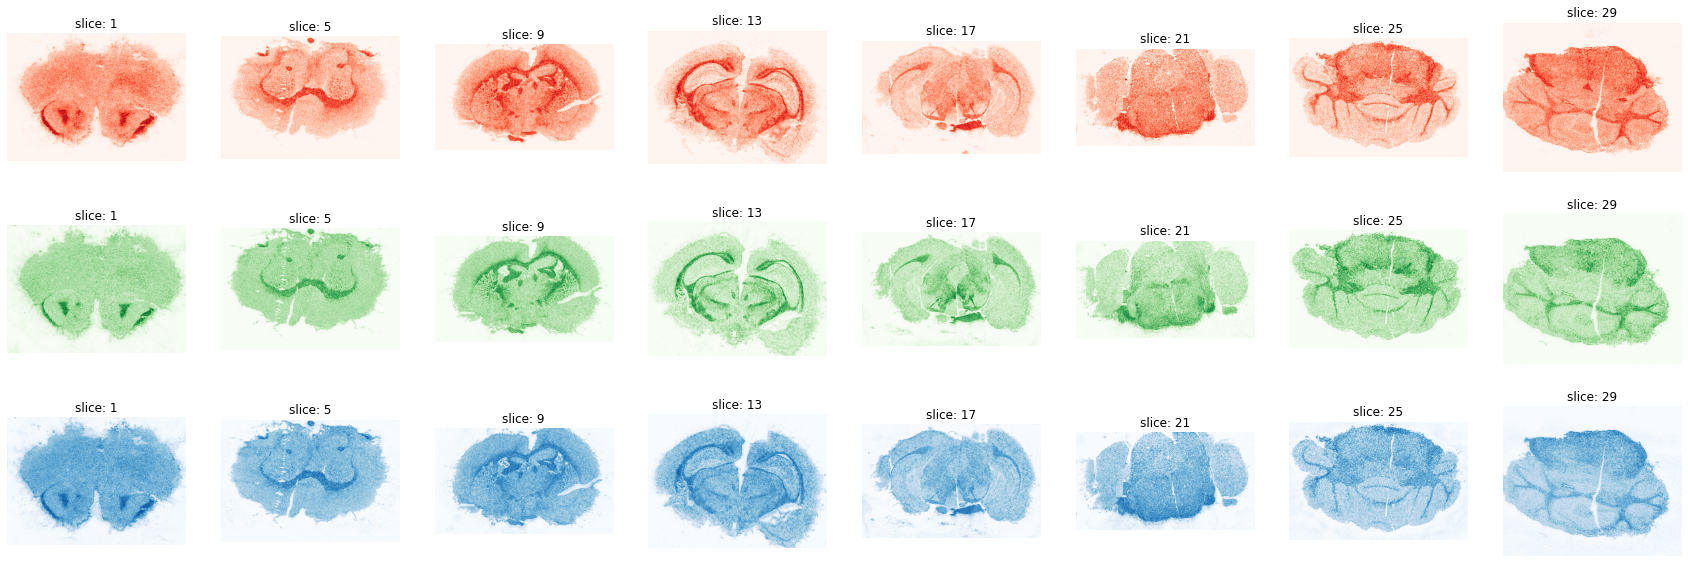

In [8]:
# Get an overview of the quality of the slices used for the registration with the current lipid selection
l_index_slices = list(range(1, 33, 4))
l_cmap = ["Reds", "Greens", "Blues"]
fig, ll_ax = plt.subplots(3, len(l_index_slices), figsize=(30, 10))

# Loop over slices and compute image for each lipid selection
for i, index in enumerate(l_index_slices):
    for j, l_index_to_keep in enumerate(ll_index_to_keep):
        image = np.sum(
            [
                image[0]
                for index_lipid, image in enumerate(dic_l_images[index])
                if index_lipid in l_index_to_keep and len(image[0].shape) > 0
            ],
            axis=0,
        )
        image_norm = image / np.max(image) * 255
        ll_ax[j, i].imshow(image_norm, cmap=l_cmap[j])
        ll_ax[j, i].axis("off")
        ll_ax[j, i].set_title("slice: " + str(index))

plt.savefig("notebooks/server/data/images/lipidschannels.png")
plt.show()


### Record the lipid selection as RGB image under tiff format for each slice

In [11]:
# Loop over slices
for slice_name in l_slices:
    index_slice = int(slice_name.split("s")[1])
    image_tiff = []
    # Loop over lipid selection
    for j, l_index_to_keep in enumerate(ll_index_to_keep):
        image = np.sum(
            [
                image[0]
                for index_lipid, image in enumerate(dic_l_images[index_slice])
                if index_lipid in l_index_to_keep and len(image[0].shape) > 0
            ],
            axis=0,
        )
        image_norm = image / np.max(image) * 255
        image_tiff.append(image_norm)

    # Export to tiff
    to_tiff(
        image_tiff,
        "notebooks/server/data/images/tiff/slice_" + str(index_slice) + ".tiff",
        image_name="slice_" + str(index_slice),
        pixel_size=25,
    )



/home/colas/miniconda3/lib/python3.9/site-packages/xtiff/tiff.py:96: UserWarning: The specified OME-TIFF file name does not end with .ome.tiff: notebooks/server/data/images/tiff/slice_9.tiff
  warnings.warn('The specified OME-TIFF file name does not end with .ome.tiff: {}'.format(file))
/home/colas/miniconda3/lib/python3.9/site-packages/xtiff/tiff.py:96: UserWarning: The specified OME-TIFF file name does not end with .ome.tiff: notebooks/server/data/images/tiff/slice_8.tiff
  warnings.warn('The specified OME-TIFF file name does not end with .ome.tiff: {}'.format(file))
/home/colas/miniconda3/lib/python3.9/site-packages/xtiff/tiff.py:96: UserWarning: The specified OME-TIFF file name does not end with .ome.tiff: notebooks/server/data/images/tiff/slice_7.tiff
  warnings.warn('The specified OME-TIFF file name does not end with .ome.tiff: {}'.format(file))
/home/colas/miniconda3/lib/python3.9/site-packages/xtiff/tiff.py:96: UserWarning: The specified OME-TIFF file name does not end with .om